<a href="https://colab.research.google.com/github/Seouyang/Today-I-Learned/blob/master/variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder

In [2]:
#setting
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image

In [3]:
#hyperparameters
batch_size = 128
learning_rate = 1e-3
num_epochs = 10

In [4]:
#data
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [5]:
#dataloader
dataloaders = {}
dataloaders['train'] = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
dataloaders['val'] = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

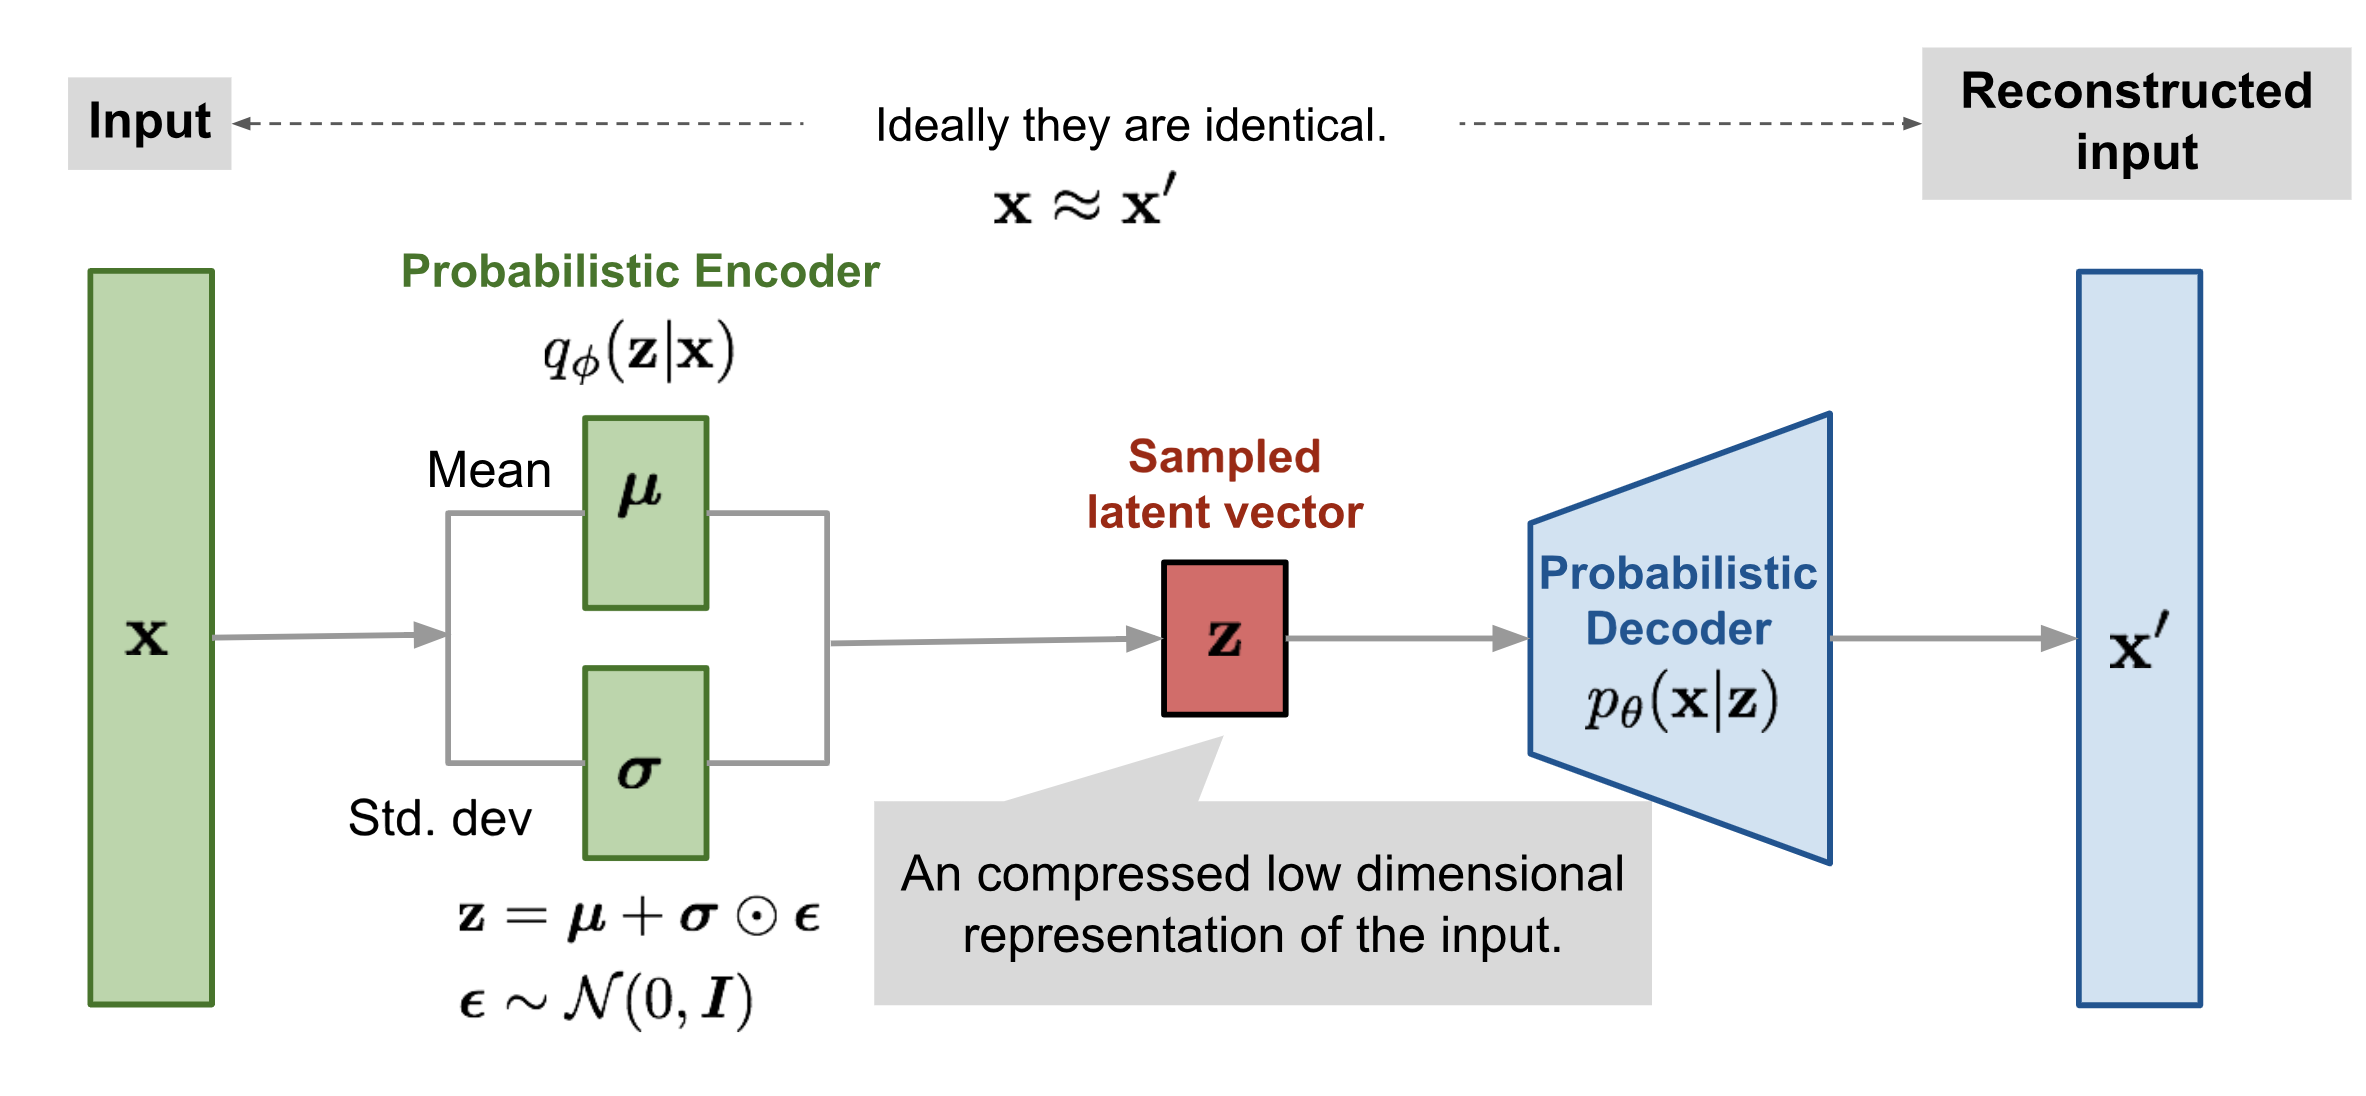

In [6]:
class VariationalAutoencoder(nn.Module):
  def __init__(self):
    super(VariationalAutoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(28*28, 256),
        nn.Tanh()
    )

    self.fc_mu = nn.Linear(256, 10)
    self.fc_var = nn.Linear(256, 10)

    self.decoder = nn.Sequential(
        nn.Linear(10, 256),
        nn.Tanh(),
        nn.Linear(256, 28*28),
        nn.Sigmoid()
    )

  def encode(self, x):
    h = self.encoder(x)
    mu = self.fc_mu(h)
    log_var = self.fc_var(h)
    return mu, log_var
  
  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    return mu + eps*std
  
  def decode(self, z):
    recon = self.decoder(z)
    return recon
  
  def forward(self, x):
    batch_size = x.size(0)
    mu, log_var = self.encode(x.view(batch_size, -1))
    z = self.reparameterize(mu, log_var)
    out = self.decode(z)
    return out, mu, log_var

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


To make the encoder output distributions similar to standard Gaussian, use the KL divergence which is a measure of distance between 2 probability distributions.

$KL\{N(\mu,\sigma), N(0,1)\}=\frac{1}{2}[\mu^2+\sigma^2-log(\sigma^2)-1]$


Total loss is the sum of cross entropy loss and KL divergence.

In [8]:
BCE = torch.nn.BCELoss(reduction='sum')

def loss_func(x, recon_x, mu, log_var):
  BCE_loss = BCE(recon_x, x.view(-1, 784))
  KLD_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  return BCE_loss + KLD_loss

In [9]:
model = VariationalAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
  since = time.time()

  train_loss_history = []
  val_loss_history = []

  best_model_wts = copy.deepcopy(model.state_dict())
  best_val_loss = 100000000

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs, mu, log_var = model(inputs)
          loss = criterion(inputs, outputs, mu, log_var)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item()
      
      epoch_loss = running_loss / len(dataloaders[phase].dataset)

      print('{} Loss: {:.4f}'.format(phase, epoch_loss))

      if phase == 'train':
        train_loss_history.append(epoch_loss)
      if phase == 'val':
        val_loss_history.append(epoch_loss)
      if phase == 'val' and epoch_loss < best_val_loss:
        best_val_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())
    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Loss: {:4f}'.format(best_val_loss))

  model.load_state_dict(best_model_wts)
  return model, train_loss_history, val_loss_history

In [11]:
best_model, train_loss_history, val_loss_history = train_model(model, dataloaders, loss_func, optimizer, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 176.9865
val Loss: 143.7574

Epoch 1/9
----------
train Loss: 138.7670
val Loss: 134.4602

Epoch 2/9
----------
train Loss: 132.0695
val Loss: 129.3780

Epoch 3/9
----------
train Loss: 127.7568
val Loss: 125.6260

Epoch 4/9
----------
train Loss: 124.4746
val Loss: 123.0985

Epoch 5/9
----------
train Loss: 122.1323
val Loss: 121.0968

Epoch 6/9
----------
train Loss: 120.1431
val Loss: 119.4771

Epoch 7/9
----------
train Loss: 118.6398
val Loss: 117.9760

Epoch 8/9
----------
train Loss: 117.4203
val Loss: 117.0398

Epoch 9/9
----------
train Loss: 116.4007
val Loss: 116.2195

Training complete in 2m 2s
Best val Loss: 116.219451


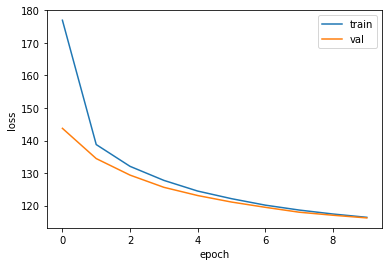

In [12]:
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [13]:
#test
with torch.no_grad():
  running_loss = 0.0
  for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)

    outputs, mu, log_var = best_model(inputs)
    test_loss = loss_func(inputs, outputs, mu, log_var)

    running_loss += test_loss.item()
  
  test_loss = running_loss / len(dataloaders['test'].dataset)
  print(test_loss)

115.47821149902343


torch.Size([16, 784])


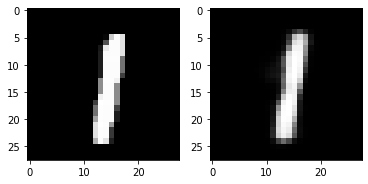

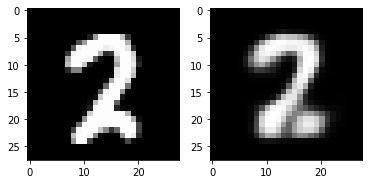

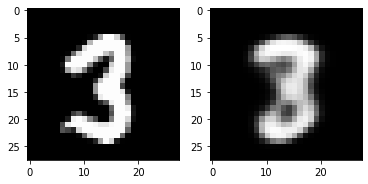

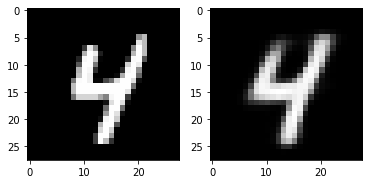

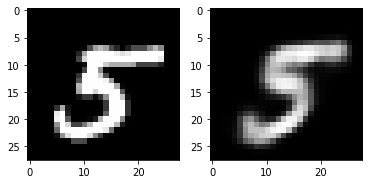

In [14]:
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

for i in range(5):
  plt.subplot(1, 2, 1)
  plt.imshow(torch.squeeze(inputs[i]).cpu().numpy(), cmap='gray')
  plt.subplot(1, 2, 2)
  plt.imshow(out_img[i].numpy().reshape(28, 28), cmap='gray')
  plt.show()

In [15]:
#visualizing MNIST
np.random.seed(42)
from sklearn.manifold import TSNE

In [16]:
train_dataset_array = mnist_train.dataset.data.numpy() / 255
train_dataset_array = np.float32(train_dataset_array)
labels = mnist_train.dataset.targets.numpy()

In [17]:
subset_indices = []
subset_indices_per_class = []

for i in range(10):
  indices = np.where(labels == i)[0]
  subset_size = len(indices) // 6
  subset_indices += indices[:subset_size].tolist()
  subset_indices_per_class.append(indices[:subset_size].tolist())

train_dataset_array = train_dataset_array[subset_indices]
labels = labels[subset_indices]

In [18]:
train_dataset_array = torch.tensor(train_dataset_array)
inputs = train_dataset_array.to(device)
outputs, mu, log_var = best_model(inputs)

In [19]:
encoded = mu.cpu().detach().numpy()
tsne = TSNE()
X_train_2D = tsne.fit_transform(encoded)
X_train_2D = (X_train_2D - X_train_2D.min()) / (X_train_2D.max() - X_train_2D.min())

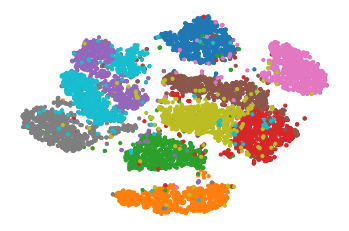

In [20]:
plt.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=labels, s=10, cmap='tab10')
plt.axis('off')
plt.show()

In [21]:
#Generate MNIST images from only the sampled latent vectors
encoded.shape

(9996, 10)

In [22]:
mean_encoded = []
for i in range(10):
  mean_encoded.append(encoded[np.where(labels == i)[0]].mean(axis=0))

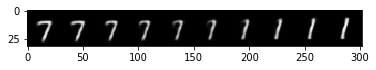

In [26]:
selected_class = [1, 7]
samples = []

with torch.no_grad():
  for idx, coef in enumerate(np.linspace(0, 1, 10)):
    interpolated = coef * mean_encoded[selected_class[0]] + (1.- coef) * mean_encoded[selected_class[1]]
    samples.append(interpolated)
  samples = np.stack(samples)
  z = torch.tensor(samples).to(device)
  generated = best_model.decoder(z)

generated = generated.view(10, 1, 28, 28)
img = make_grid(generated, nrow=10)
npimg = img.cpu().numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

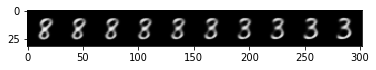

In [28]:
selected_class = [3, 8]
samples = []

with torch.no_grad():
  for idx, coef in enumerate(np.linspace(0, 1, 10)):
    interpolated = coef * mean_encoded[selected_class[0]] + (1.- coef) * mean_encoded[selected_class[1]]
    samples.append(interpolated)
  samples = np.stack(samples)
  z = torch.tensor(samples).to(device)
  generated = best_model.decoder(z)

generated = generated.view(10, 1, 28, 28)
img = make_grid(generated, nrow=10)
npimg = img.cpu().numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')